In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import tensorflow.keras, os
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import sklearn.metrics as met
from sklearn.metrics import multilabel_confusion_matrix as mcm
import numpy as np
import itertools

In [3]:
trdata = ImageDataGenerator(rescale = 1./255)
traindata = trdata.flow_from_directory(directory="/content/drive/MyDrive/Covid-Train",target_size=(299,299))
tsdata = ImageDataGenerator(rescale = 1./255)
testdata = tsdata.flow_from_directory(directory="/content/drive/MyDrive/Covid-Test", target_size=(299,299))
teacher = ImageDataGenerator(rescale = 1./255)
teacherData = teacher.flow_from_directory(directory="/content/drive/MyDrive/Teacher", target_size=(299,299))

Found 16500 images belonging to 4 classes.
Found 3132 images belonging to 4 classes.
Found 1533 images belonging to 4 classes.


In [5]:
VGG = tensorflow.keras.applications.VGG16(input_shape=(299, 299, 3), include_top= False, weights='imagenet')
VGG.trainable = False
model = tensorflow.keras.Sequential([
                                     VGG, 
                                     tensorflow.keras.layers.Flatten(), 
                                     tensorflow.keras.layers.Dense(units=256, activation='relu'),
                                     tensorflow.keras.layers.Dense(units=256, activation='relu'),
                                     tensorflow.keras.layers.Dense(units=4, activation='softmax')
                                     ])
model.compile(optimizer = 'adam', loss = tensorflow.keras.losses.categorical_crossentropy, metrics=['accuracy', 'mse'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               10617088  
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 25,398,596
Trainable params: 10,683,908
Non-trainable params: 14,714,688
_________________________________________________________________


Epoch 1/12
100/100 [==============================] - 3126s 31s/step - loss: 1.7991 - accuracy: 0.6481 - mse: 0.1394 - val_loss: 0.9077 - val_accuracy: 0.7031 - val_mse: 0.1156
Epoch 2/12
100/100 [==============================] - 3093s 31s/step - loss: 0.4383 - accuracy: 0.8435 - mse: 0.0588 - val_loss: 1.0303 - val_accuracy: 0.6875 - val_mse: 0.1173
Epoch 3/12
100/100 [==============================] - 3088s 31s/step - loss: 0.3640 - accuracy: 0.8626 - mse: 0.0499 - val_loss: 0.5982 - val_accuracy: 0.7875 - val_mse: 0.0814
Epoch 4/12
100/100 [==============================] - 3079s 31s/step - loss: 0.3276 - accuracy: 0.8760 - mse: 0.0460 - val_loss: 0.4397 - val_accuracy: 0.8344 - val_mse: 0.0608
Epoch 5/12
100/100 [==============================] - 3073s 31s/step - loss: 0.3225 - accuracy: 0.8816 - mse: 0.0447 - val_loss: 0.6882 - val_accuracy: 0.7375 - val_mse: 0.0969
Epoch 6/12
100/100 [==============================] - 3084s 31s/step - loss: 0.2356 - accuracy: 0.9245 - mse: 0.031

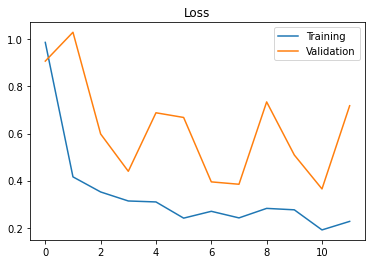

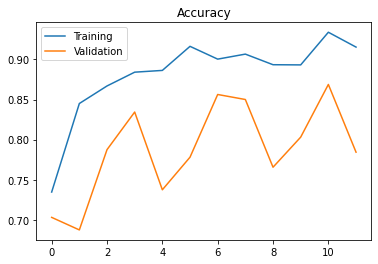

In [ ]:
hist = model.fit(traindata, steps_per_epoch=100, epochs=12, validation_data= testdata, validation_steps=10)
model.save('/content/drive/MyDrive/SaveState3.h5')

plot1=plt.figure(1)
plt.title('Loss')
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()
plot2=plt.figure(2)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='Training')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

In [6]:
model=load_model('/content/drive/MyDrive/SaveState3.h5')

yhat_probs = model.predict(testdata, verbose=0)


In [7]:
yhat_classes = model.predict_classes(testdata, verbose=0)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [11]:

#yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 0]
testY = testdata.classes
accuracy = met.accuracy_score(testY, yhat_classes)
print('Accuracy: %f' % accuracy)
precision = met.precision_score(testY, yhat_classes, average='weighted')
print('Precision: %f' % precision)
recall = met.recall_score(testY, yhat_classes, average='weighted')
print('Recall: %f' % recall)
f1 = met.f1_score(testY, yhat_classes, average='weighted')
print('F1 score: %f' % f1)
matrix = met.confusion_matrix(testY, yhat_classes)
print(matrix)

Accuracy: 0.292784
Precision: 0.287048
Recall: 0.292784
F1 score: 0.285267
[[158 299 384  59]
 [185 331 398  70]
 [195 314 412  87]
 [ 47  86  91  16]]


In [12]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
  accuracy = np.trace(cm) / float(np.sum(cm))
  misclass = 1 - accuracy
  if cmap is None:
    cmap = plt.get_cmap('Blues')
  plt.figure(figsize=(8, 6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  thresh = cm.max() / 1.5 if normalize else cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if normalize:
      plt.text(j, i, "{:0.4f}".format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
    else:
      plt.text(j, i, "{:,}".format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
  plt.show()

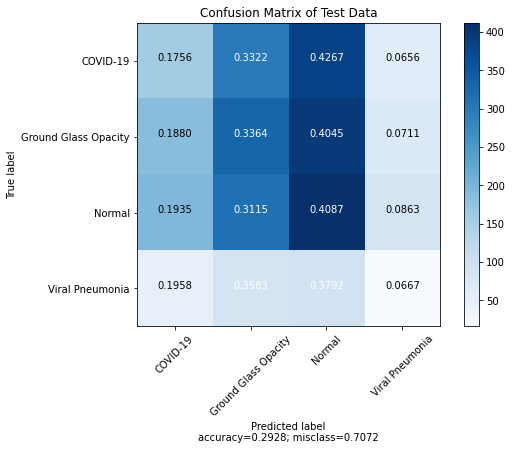

In [13]:
plot_confusion_matrix(cm = matrix, normalize = True, target_names = ["COVID-19", "Ground Glass Opacity", "Normal", "Viral Pneumonia"], title = "Confusion Matrix of Test Data")

[[1.5835997e-17 1.0000000e+00 8.1893881e-10 7.0900971e-36]]
Diagnosed with Ground Glass Opacity!
[[3.8274371e-19 1.0000000e+00 5.6922542e-09 0.0000000e+00]]
Diagnosed with Ground Glass Opacity!
[[0. 0. 1. 0.]]
Healthy
[[0.0000000e+00 0.0000000e+00 5.6737674e-11 1.0000000e+00]]
Diagnosed with Viral Pneumonia!


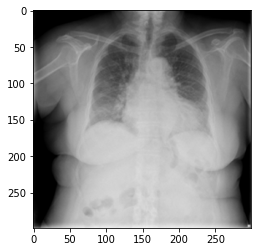

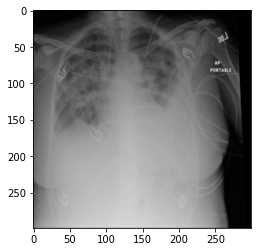

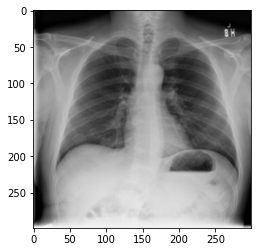

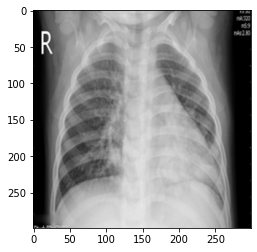

In [14]:
def getOutput(stri):
  img= image.load_img(stri, target_size=(299,299))
  img=np.asarray(img)
  plt.imshow(img)
  img=np.expand_dims(img,axis=0)
  saved_model=load_model('/content/drive/MyDrive/SaveState3.h5')
  output=saved_model.predict(img)
  print(output)
  maxi=0
  for i in range(4):
    if(output[0][i]>output[0][maxi]):
      maxi=i
  diction = {0:'Diagnosed with COVID-19!', 1:'Diagnosed with Ground Glass Opacity!', 2: 'Healthy', 3: 'Diagnosed with Viral Pneumonia!'}
  print(diction[maxi])

plot1=plt.figure(1)
getOutput('/content/drive/MyDrive/COVID-3403.png')
plot2=plt.figure(2)
getOutput('/content/drive/MyDrive/Lung_Opacity-6004.png')
plot3=plt.figure(3)
getOutput('/content/drive/MyDrive/Normal-10182.png')
plot4=plt.figure(4)
getOutput('/content/drive/MyDrive/Viral Pneumonia-1339.png')